In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/university-questions/train.json
/kaggle/input/university-questions/test.json
/kaggle/input/pm-109337295-at-02-13-2026-07-22-08/pydantic_core-2.41.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pm-109337295-at-02-13-2026-07-22-08/spacy_loggers-1.0.5-py3-none-any.whl
/kaggle/input/pm-109337295-at-02-13-2026-07-22-08/cymem-2.0.13-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl
/kaggle/input/pm-109337295-at-02-13-2026-07-22-08/__script__.py
/kaggle/input/pm-109337295-at-02-13-2026-07-22-08/shellingham-1.5.4-py2.py3-none-any.whl
/kaggle/input/pm-109337295-at-02-13-2026-07-22-08/setuptools-82.0.0-py3-none-any.whl
/kaggle/input/pm-109337295-at-02-13-2026-07-22-08/nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl
/kaggle/input/pm-109337295-at-02-13-2026-07-22-08/huggingface_hub-0.34.6-py3-none-any.whl
/kaggle/input/pm-109337295-at-02-13-2026-07-22-08/nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x

Recommended Implementation Pipeline
Here is the recommended order of implementation:

Phase 1: Baseline (1-2 days)--> WE ARE HERE!

├── Preprocess text (normalize Persian, clean)

├── TF-IDF (word + char n-grams)

├── Logistic Regression + SVM with class weights

├── Evaluate with stratified 5-fold CV

└── Establish baseline F1 score

Phase 2: Feature Engineering (1 day)

├── Add handcrafted features (length, question words, entity presence, etc.)

├── Combine with TF-IDF features

├── Try LightGBM / XGBoost

└── Compare against Phase 1

Phase 3: Transformer Fine-tuning (2-3 days)

├── Fine-tune ParsBERT on the task

├── Fine-tune XLM-RoBERTa as alternative

├── Apply class weighting or focal loss

├── Hyperparameter tuning (LR, epochs, batch size)

└── Compare against Phase 1 & 2

Phase 4: Optimization (1-2 days)

├── Data augmentation (back-translation, LLM-generated)

├── Ensemble top models

├── Optionally: concat transformer embeddings + handcrafted features

└── Final evaluation and model selection

In [2]:
# ============================================
# 1. Import Libraries
# ============================================
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette('Set2')


In [3]:
# ============================================
# 2. Load Dataset
# ============================================
with open('/kaggle/input/university-questions/train.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nData Types:")
print(df.dtypes)
print(f"\nFirst 5 rows:")
df.head()


DATASET OVERVIEW
Shape: (900, 4)
Columns: ['question', 'is_ambiguous', 'clarifications', 'id']

Data Types:
question          object
is_ambiguous       int64
clarifications    object
id                object
dtype: object

First 5 rows:


,question,is_ambiguous,clarifications,id
0,حداقل نمره قبولی در هر درس برای دانشجویان مقطع...,0,[],1
1,حداکثر سنوات مجاز تحصیل در دوره کارشناسی پیوست...,0,[],2
2,آیا دانشجوی کارشناسی می‌تواند با معدل بالای ۱۷...,0,[],3
3,دانشجوی کارشناسی ارشد حداکثر چند نیمسال می‌توا...,0,[],4
4,آخرین مهلت برای حذف تک‌درس (حذف اضطراری) در طو...,0,[],5


In [4]:
# ============================================
# 3. Basic Statistics
# ============================================
print("=" * 60)
print("BASIC STATISTICS")
print("=" * 60)
print(f"Total samples: {len(df)}")
print(f"Unique IDs: {df['id'].nunique()}")
print(f"Any duplicate IDs: {len(df) - df['id'].nunique()}")
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nNull in clarifications (None or empty list):")
print(f"  None values: {df['clarifications'].isna().sum()}")
print(f"  Empty lists: {df['clarifications'].apply(lambda x: len(x) == 0 if isinstance(x, list) else False).sum()}")


BASIC STATISTICS
Total samples: 900
Unique IDs: 900
Any duplicate IDs: 0

Missing values:
question          0
is_ambiguous      0
clarifications    0
id                0
dtype: int64

Null in clarifications (None or empty list):
  None values: 0
  Empty lists: 449


TARGET: is_ambiguous
  Class 0 (Not Ambiguous): 450 samples (50.0%)
  Class 1 (Ambiguous): 450 samples (50.0%)

Imbalance Ratio: 1.00


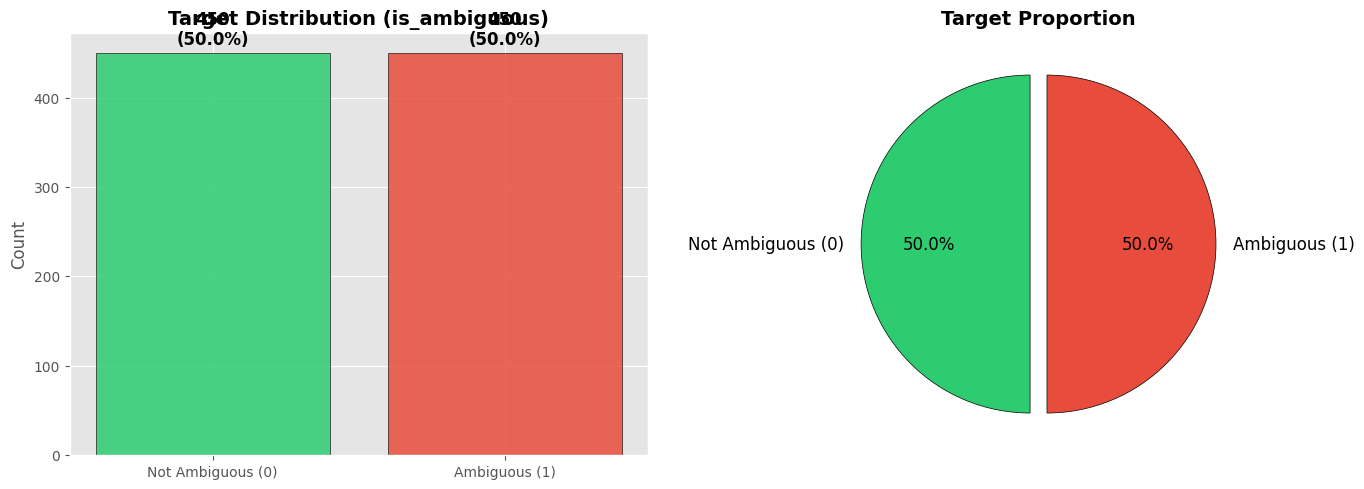

In [5]:
# ============================================
# 4. Target Distribution (is_ambiguous)
# ============================================
print("=" * 60)
print("TARGET: is_ambiguous")
print("=" * 60)

target_counts = df['is_ambiguous'].value_counts().sort_index()
target_pcts = df['is_ambiguous'].value_counts(normalize=True).sort_index() * 100

for cls in target_counts.index:
    label = "Ambiguous" if cls == 1 else "Not Ambiguous"
    print(f"  Class {cls} ({label}): {target_counts[cls]} samples ({target_pcts[cls]:.1f}%)")

imbalance_ratio = target_counts.max() / target_counts.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#2ecc71', '#e74c3c']
labels_map = {0: 'Not Ambiguous (0)', 1: 'Ambiguous (1)'}
plot_labels = [labels_map[i] for i in target_counts.index]

# Bar chart
bars = axes[0].bar(plot_labels, target_counts.values, color=colors, edgecolor='black', alpha=0.85)
axes[0].set_title('Target Distribution (is_ambiguous)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for bar, count, pct in zip(bars, target_counts.values, target_pcts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + len(df)*0.01,
                f'{count}\n({pct:.1f}%)', ha='center', fontsize=12, fontweight='bold')

# Pie chart
axes[1].pie(target_counts.values, labels=plot_labels, autopct='%1.1f%%',
            colors=colors, startangle=90, explode=[0.05]*len(target_counts),
            textprops={'fontsize': 12}, wedgeprops={'edgecolor': 'black'})
axes[1].set_title('Target Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [6]:
# ============================================
# 5. Question Text Analysis
# ============================================
print("=" * 60)
print("QUESTION TEXT ANALYSIS")
print("=" * 60)

df['question_char_len'] = df['question'].apply(len)
df['question_word_count'] = df['question'].apply(lambda x: len(x.split()))
df['question_token_count'] = df['question'].apply(lambda x: len(re.findall(r'\S+', x)))

# Check if questions end with question mark
df['has_question_mark'] = df['question'].apply(lambda x: x.strip().endswith('؟') or x.strip().endswith('?'))

print("Character Length Statistics:")
print(df['question_char_len'].describe().to_string())
print()

print("Word Count Statistics:")
print(df['question_word_count'].describe().to_string())
print()

print(f"Questions ending with '?' or '؟': {df['has_question_mark'].sum()} ({df['has_question_mark'].mean()*100:.1f}%)")


QUESTION TEXT ANALYSIS
Character Length Statistics:
count    900.000000
mean      47.010000
std       19.963451
min       11.000000
25%       31.000000
50%       44.000000
75%       61.000000
max      122.000000

Word Count Statistics:
count    900.000000
mean       8.672222
std        3.710357
min        2.000000
25%        6.000000
50%        8.000000
75%       11.000000
max       23.000000

Questions ending with '?' or '؟': 866 (96.2%)


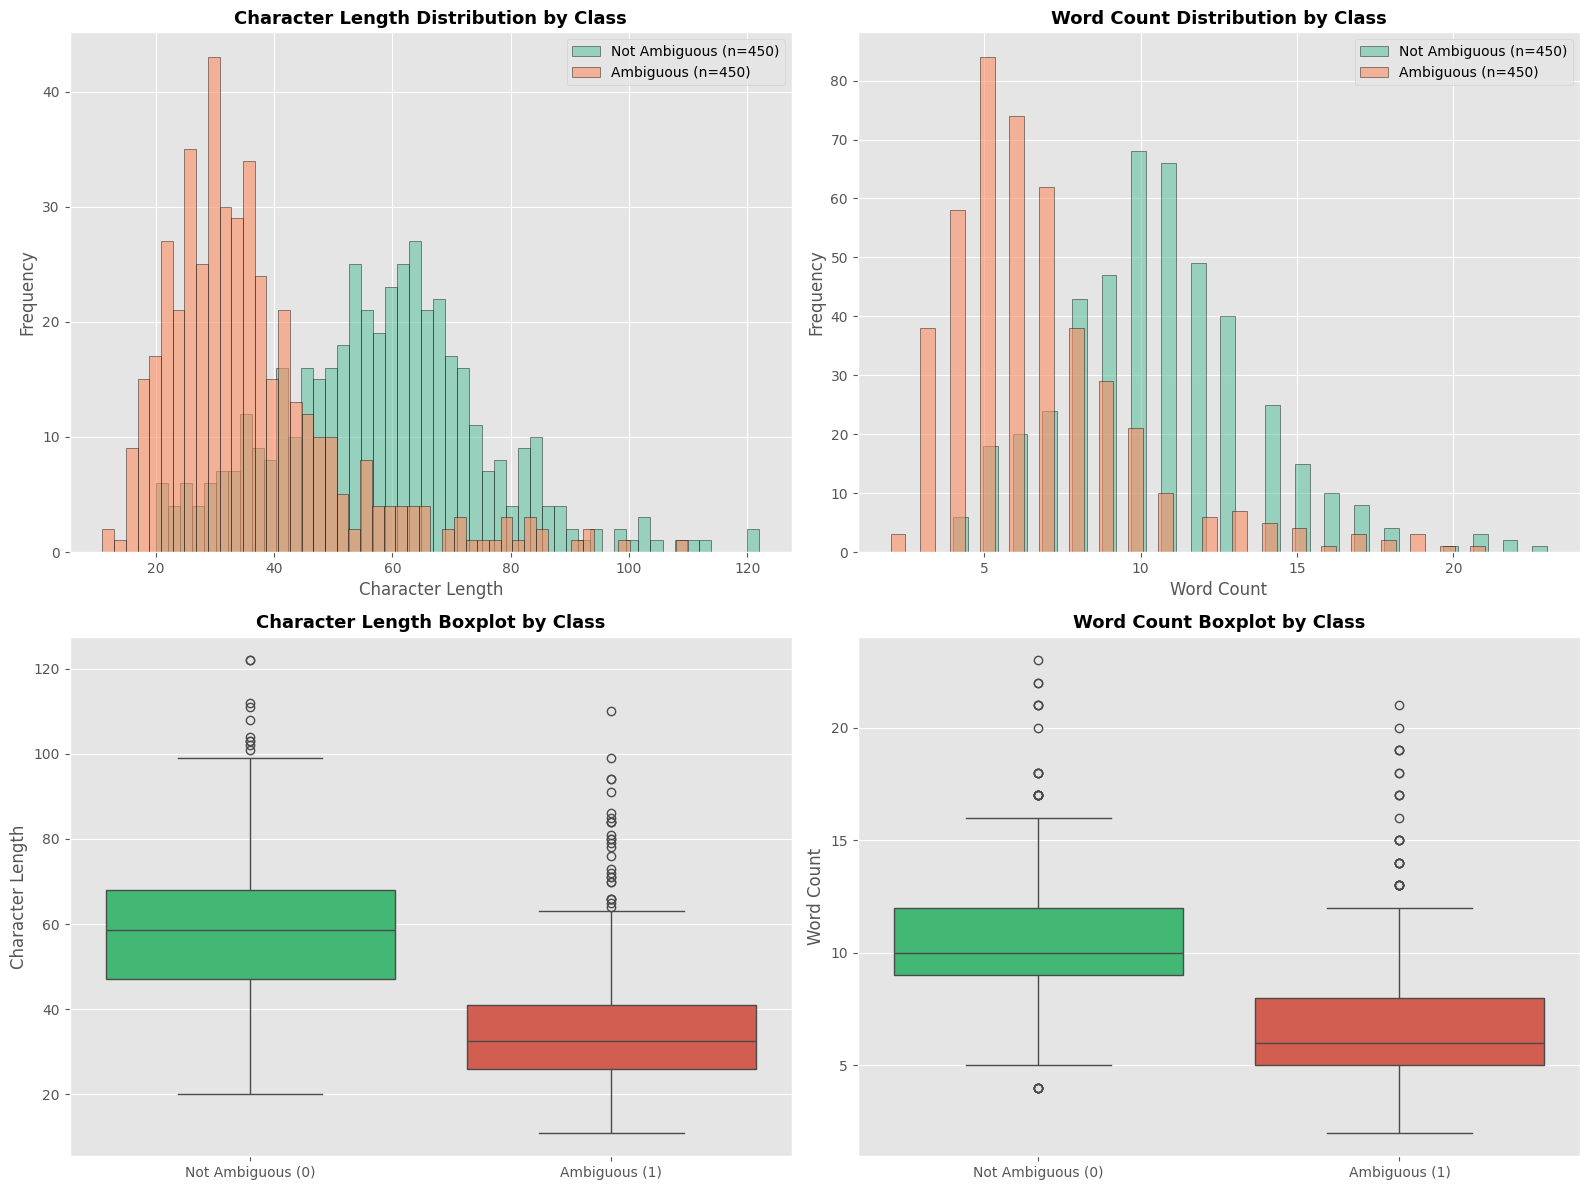

QUESTION LENGTH STATS BY CLASS

  Class 0 (Not Ambiguous):
    Char Length  -> Mean: 58.3, Median: 58.5, Std: 17.5
    Word Count   -> Mean: 10.6, Median: 10.0, Std: 3.2

  Class 1 (Ambiguous):
    Char Length  -> Mean: 35.7, Median: 32.5, Std: 15.4
    Word Count   -> Mean: 6.7, Median: 6.0, Std: 3.1


In [7]:
# ============================================
# 6. Question Length Distribution by Class
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

class_labels = {0: 'Not Ambiguous', 1: 'Ambiguous'}

# 6a. Character length histogram
for cls in [0, 1]:
    subset = df[df['is_ambiguous'] == cls]
    axes[0][0].hist(subset['question_char_len'], bins=50, alpha=0.6,
                    label=f'{class_labels[cls]} (n={len(subset)})', edgecolor='black')
axes[0][0].set_title('Character Length Distribution by Class', fontsize=13, fontweight='bold')
axes[0][0].set_xlabel('Character Length')
axes[0][0].set_ylabel('Frequency')
axes[0][0].legend()

# 6b. Word count histogram
for cls in [0, 1]:
    subset = df[df['is_ambiguous'] == cls]
    axes[0][1].hist(subset['question_word_count'], bins=40, alpha=0.6,
                    label=f'{class_labels[cls]} (n={len(subset)})', edgecolor='black')
axes[0][1].set_title('Word Count Distribution by Class', fontsize=13, fontweight='bold')
axes[0][1].set_xlabel('Word Count')
axes[0][1].set_ylabel('Frequency')
axes[0][1].legend()

# 6c. Boxplot - char length
sns.boxplot(x='is_ambiguous', y='question_char_len', data=df, ax=axes[1][0], palette=colors)
axes[1][0].set_title('Character Length Boxplot by Class', fontsize=13, fontweight='bold')
axes[1][0].set_xticklabels(['Not Ambiguous (0)', 'Ambiguous (1)'])
axes[1][0].set_xlabel('')
axes[1][0].set_ylabel('Character Length')

# 6d. Boxplot - word count
sns.boxplot(x='is_ambiguous', y='question_word_count', data=df, ax=axes[1][1], palette=colors)
axes[1][1].set_title('Word Count Boxplot by Class', fontsize=13, fontweight='bold')
axes[1][1].set_xticklabels(['Not Ambiguous (0)', 'Ambiguous (1)'])
axes[1][1].set_xlabel('')
axes[1][1].set_ylabel('Word Count')

plt.tight_layout()
plt.show()

# Stats per class
print("=" * 60)
print("QUESTION LENGTH STATS BY CLASS")
print("=" * 60)
for cls in [0, 1]:
    subset = df[df['is_ambiguous'] == cls]
    print(f"\n  Class {cls} ({class_labels[cls]}):")
    print(f"    Char Length  -> Mean: {subset['question_char_len'].mean():.1f}, "
          f"Median: {subset['question_char_len'].median():.1f}, "
          f"Std: {subset['question_char_len'].std():.1f}")
    print(f"    Word Count   -> Mean: {subset['question_word_count'].mean():.1f}, "
          f"Median: {subset['question_word_count'].median():.1f}, "
          f"Std: {subset['question_word_count'].std():.1f}")


CLARIFICATIONS ANALYSIS
Number of Clarifications per Sample:
count    900.000000
mean       1.200000
std        1.408697
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        7.000000

Distribution of clarification counts:
  0 clarifications: 449 samples (49.9%)
  1 clarifications: 93 samples (10.3%)
  2 clarifications: 167 samples (18.6%)
  3 clarifications: 127 samples (14.1%)
  4 clarifications: 51 samples (5.7%)
  5 clarifications: 11 samples (1.2%)
  6 clarifications: 1 samples (0.1%)
  7 clarifications: 1 samples (0.1%)


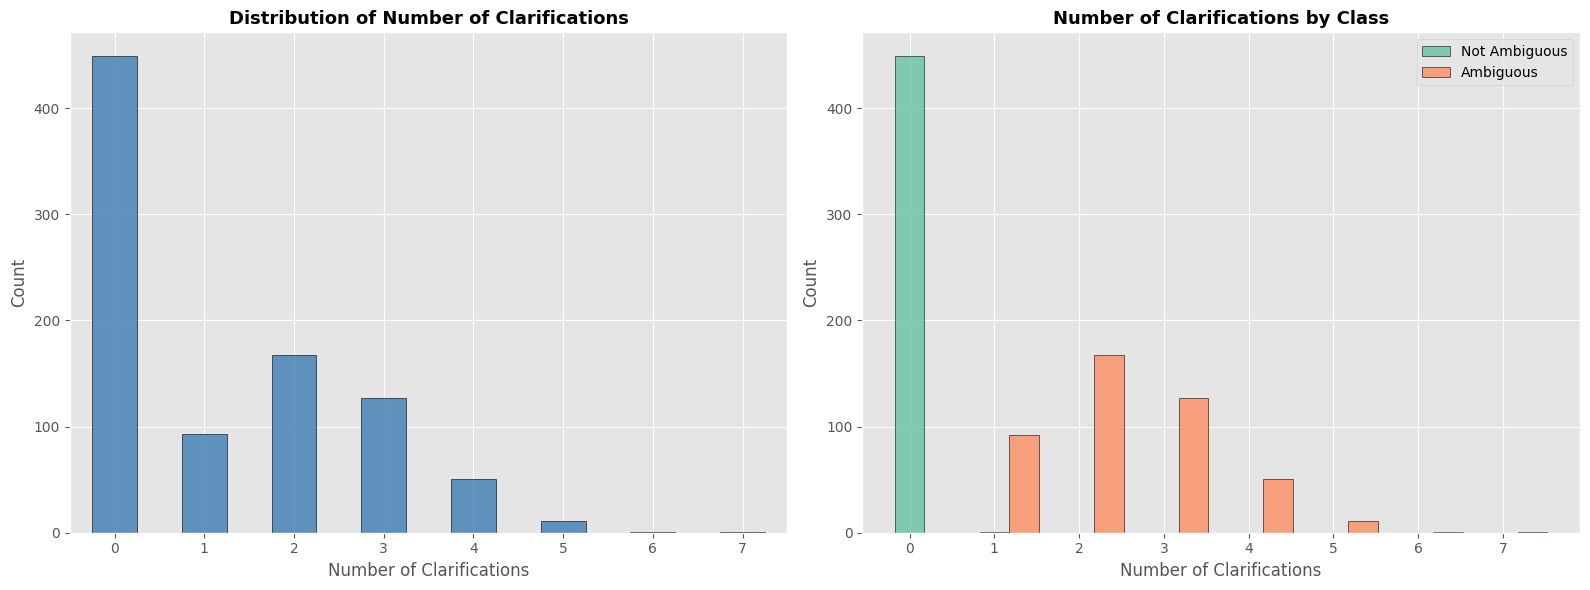

In [8]:
# ============================================
# 7. Clarifications Analysis
# ============================================
print("=" * 60)
print("CLARIFICATIONS ANALYSIS")
print("=" * 60)

df['num_clarifications'] = df['clarifications'].apply(lambda x: len(x) if isinstance(x, list) else 0)

print("Number of Clarifications per Sample:")
print(df['num_clarifications'].describe().to_string())
print()

print("Distribution of clarification counts:")
clar_dist = df['num_clarifications'].value_counts().sort_index()
for num, count in clar_dist.items():
    print(f"  {num} clarifications: {count} samples ({count/len(df)*100:.1f}%)")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall distribution
clar_dist.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black', alpha=0.85)
axes[0].set_title('Distribution of Number of Clarifications', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Number of Clarifications')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# By class
for cls in [0, 1]:
    subset = df[df['is_ambiguous'] == cls]
    clar_cls = subset['num_clarifications'].value_counts().sort_index()
    axes[1].bar([x + cls*0.35 for x in clar_cls.index], clar_cls.values,
               width=0.35, alpha=0.8, label=class_labels[cls], edgecolor='black')
axes[1].set_title('Number of Clarifications by Class', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Number of Clarifications')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()


WORD FREQUENCY ANALYSIS


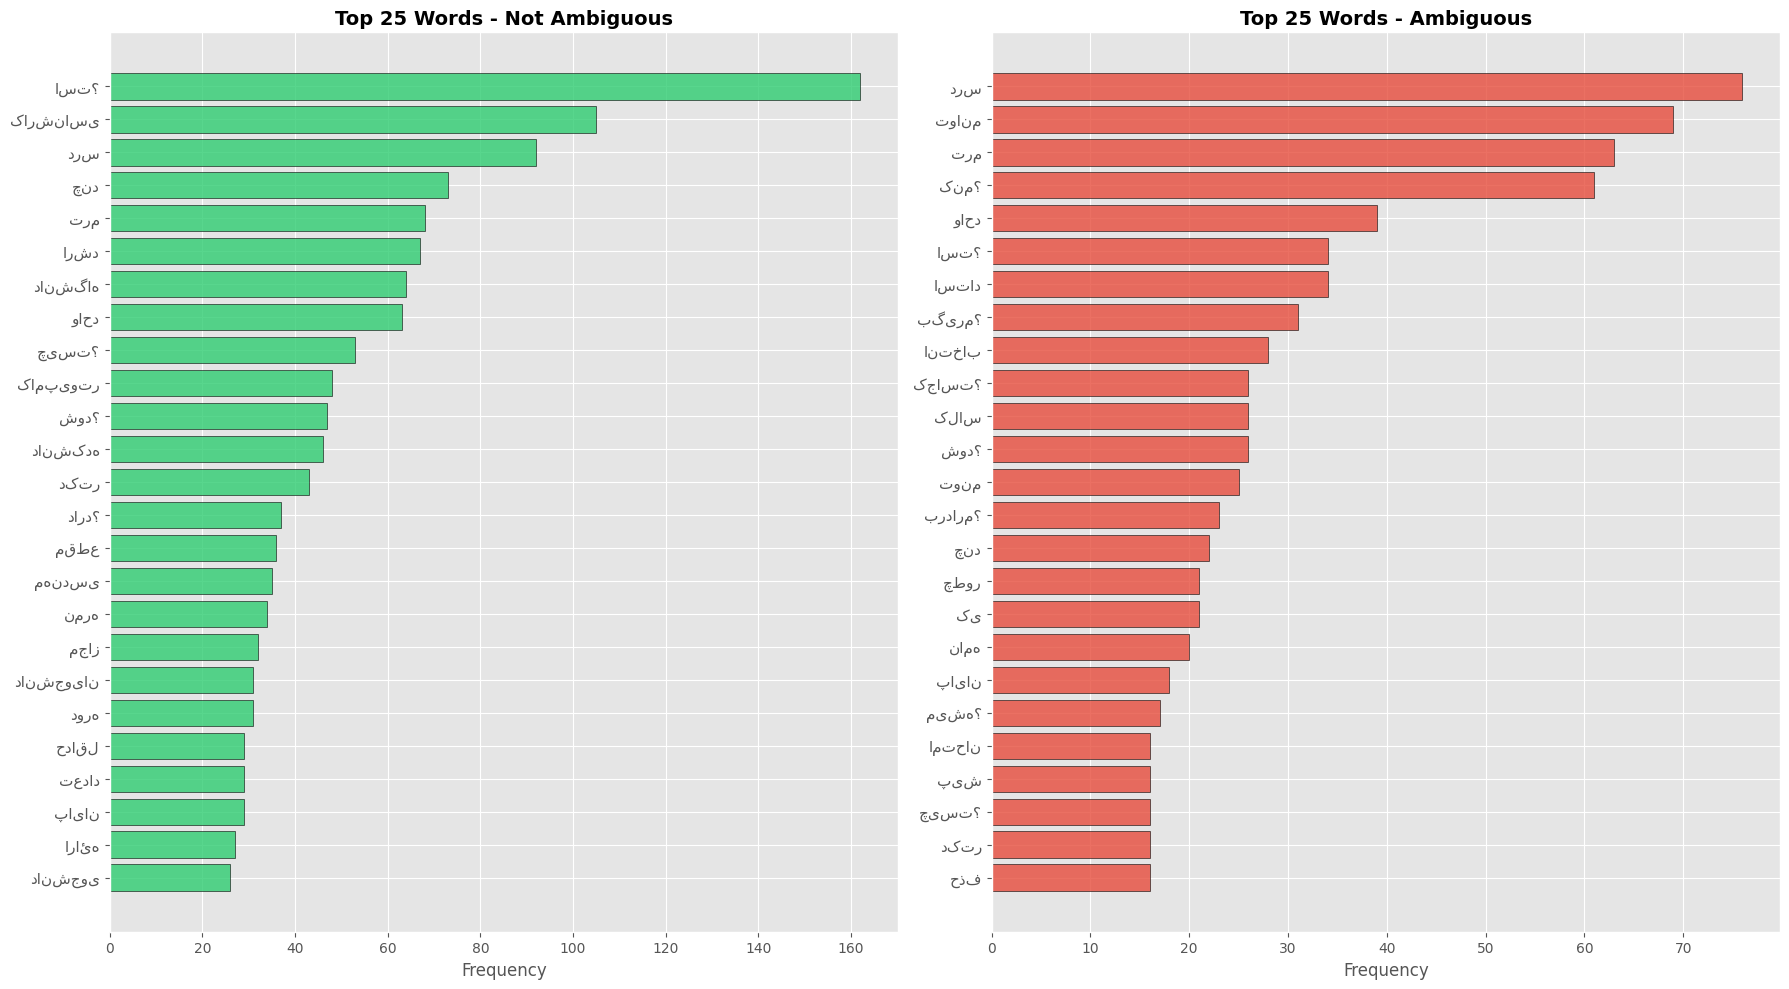

In [9]:

print("=" * 60)
print("WORD FREQUENCY ANALYSIS")
print("=" * 60)

def get_word_freq(texts, top_n=30):
    all_words = []
    for text in texts:
        words = re.findall(r'[\u0600-\u06FF\uFB8A\u067E\u0686\u06AF]+', text)
        all_words.extend(words)
    return Counter(all_words).most_common(top_n)

# Stopwords (basic Persian)
persian_stopwords = {
    'و', 'در', 'به', 'از', 'که', 'این', 'را', 'با', 'است', 'برای',
    'آن', 'یک', 'هم', 'تا', 'هر', 'من', 'بر', 'یا', 'اما', 'اگر',
    'ها', 'های', 'شما', 'ما', 'او', 'آیا', 'هست', 'نه', 'بود', 'شد',
    'خود', 'بی', 'می', 'هستم', 'هستید', 'چه', 'آن', 'شده', 'کنم',
    'کنید', 'باید', 'میشه', 'میشود', 'بشه', 'رو', 'رو', 'هم'
}

def get_word_freq_filtered(texts, top_n=30):
    all_words = []
    for text in texts:
        words = re.findall(r'[\u0600-\u06FF\uFB8A\u067E\u0686\u06AF]+', text)
        all_words.extend([w for w in words if w not in persian_stopwords and len(w) > 1])
    return Counter(all_words).most_common(top_n)

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

for idx, cls in enumerate([0, 1]):
    subset = df[df['is_ambiguous'] == cls]
    word_freq = get_word_freq_filtered(subset['question'].tolist(), top_n=25)

    words = [w[0] for w in word_freq]
    counts = [w[1] for w in word_freq]

    axes[idx].barh(range(len(words)), counts, color=colors[idx], edgecolor='black', alpha=0.8)
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words, fontsize=11)
    axes[idx].set_title(f'Top 25 Words - {class_labels[cls]}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Frequency')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()


In [10]:
# ============================================
# 11. Question Mark & Special Characters Analysis
# ============================================
print("=" * 60)
print("SPECIAL CHARACTERS ANALYSIS")
print("=" * 60)

df['has_persian_qmark'] = df['question'].apply(lambda x: '؟' in x)
df['has_english_qmark'] = df['question'].apply(lambda x: '?' in x)
df['has_any_qmark'] = df['has_persian_qmark'] | df['has_english_qmark']
df['num_qmarks'] = df['question'].apply(lambda x: x.count('؟') + x.count('?'))

print(f"Questions with Persian '؟': {df['has_persian_qmark'].sum()} ({df['has_persian_qmark'].mean()*100:.1f}%)")
print(f"Questions with English '?': {df['has_english_qmark'].sum()} ({df['has_english_qmark'].mean()*100:.1f}%)")
print(f"Questions with any '?': {df['has_any_qmark'].sum()} ({df['has_any_qmark'].mean()*100:.1f}%)")

# By class
print("\nQuestion Mark presence by class:")
qmark_by_class = pd.crosstab(df['is_ambiguous'], df['has_any_qmark'], normalize='index') * 100
qmark_by_class.columns = ['No Question Mark (%)', 'Has Question Mark (%)']
qmark_by_class.index = ['Not Ambiguous', 'Ambiguous']
print(qmark_by_class.round(1))


SPECIAL CHARACTERS ANALYSIS
Questions with Persian '؟': 868 (96.4%)
Questions with English '?': 0 (0.0%)
Questions with any '?': 868 (96.4%)

Question Mark presence by class:
               No Question Mark (%)  Has Question Mark (%)
Not Ambiguous                   2.4                   97.6
Ambiguous                       4.7                   95.3


In [11]:
# ============================================
# 12. Samples from Each Class
# ============================================
print("=" * 60)
print("SAMPLE QUESTIONS FROM EACH CLASS")
print("=" * 60)

for cls in [0, 1]:
    subset = df[df['is_ambiguous'] == cls].sample(n=min(5, len(df[df['is_ambiguous'] == cls])), random_state=42)
    print(f"\n{'~' * 50}")
    print(f"CLASS {cls}: {class_labels[cls]}")
    print(f"{'~' * 50}")
    for i, (_, row) in enumerate(subset.iterrows(), 1):
        print(f"\n  [{i}] Question: {row['question']}")
        print(f"      Clarifications ({len(row['clarifications'])}): {row['clarifications']}")


SAMPLE QUESTIONS FROM EACH CLASS

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CLASS 0: Not Ambiguous
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  [1] Question: روند دریافت ریز‌نمرات رسمی از سامانه بهستان چیست
      Clarifications (0): []

  [2] Question: آیا می‌توان مجددا در دانشگاه دولتی کارشناسی ارشد ثبت نام کرد؟
      Clarifications (0): []

  [3] Question: دکتر علیرضا طاهری (استاد دانشکده کامپیوتر) چه درس‌هایی را در دانشگاه ارائه کرده است؟
      Clarifications (0): []

  [4] Question: حداکثر تعداد دروس عمومی که دانشجو می‌تواند در یک ترم بردارد چقدر است؟
      Clarifications (0): []

  [5] Question: قالب اصلی برای نگارش رساله دکتری را از کجا میتوانم دانلود کنم؟
      Clarifications (0): []

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CLASS 1: Ambiguous
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  [1] Question: آیا میتونم از دانشکده ادبیات یک درس اضافی بردارم؟
      Clarifications (4): ['در حال حاضر در کدام دانشکده تحصیل میکنید؟', 'رشته شما چیست؟', 'مق

In [12]:
# =============================================================================
# Phase 1 - Step 1: Persian Text Preprocessing Pipeline (HAZM-POWERED)
# =============================================================================

# First, install hazm if not already installed:
# pip install hazm

import json
import re
import pandas as pd
import numpy as np
from collections import Counter
import unicodedata

# --- Hazm Imports ---
try:
    from hazm import (
        Normalizer,
        WordTokenizer,
        Lemmatizer,
        Stemmer,
        stopwords_list,
        sent_tokenize,
        word_tokenize
    )
    # Try importing InformalNormalizer (available in newer versions of hazm)
    try:
        from hazm import InformalNormalizer
        HAS_INFORMAL_NORMALIZER = True
    except ImportError:
        HAS_INFORMAL_NORMALIZER = False
        print("[WARNING] InformalNormalizer not available in your hazm version.")
        print("         Install latest version: pip install hazm --upgrade")

    HAZM_AVAILABLE = True
    print("[OK] Hazm loaded successfully.")
    if HAS_INFORMAL_NORMALIZER:
        print("[OK] InformalNormalizer is available.")
    else:
        print("[--] InformalNormalizer is NOT available.")

except ImportError:
    HAZM_AVAILABLE = False
    print("[ERROR] Hazm is not installed. Install it with: pip install hazm")
    print("        Falling back to manual preprocessing (not recommended).")


# =============================================================================
# STEP 1: LOAD DATA
# =============================================================================
print("\n" + "=" * 70)
print("STEP 1: LOADING DATA")
print("=" * 70)


# this part is hardcoded --> maybe later we need to run individually 
# This code is used for Kaggle, maybe we need to change it for local. 
with open('/kaggle/input/university-questions/train.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nClass distribution:")
print(df['is_ambiguous'].value_counts())
print(f"\nClass ratio (ambiguous=1): {df['is_ambiguous'].mean():.4f}")


# =============================================================================
# STEP 2: INITIALIZE HAZM COMPONENTS
# =============================================================================
print("\n" + "=" * 70)
print("STEP 2: INITIALIZING HAZM COMPONENTS")
print("=" * 70)

if HAZM_AVAILABLE:
    # --- Normalizer ---
    # Hazm's Normalizer handles:
    #   - Arabic Kaf/Yeh -> Persian
    #   - Diacritics removal
    #   - ZWNJ correction (adds where needed, removes where spurious)
    #   - Various Unicode normalizations
    #   - Punctuation spacing fixes
    normalizer = Normalizer()
    print("[OK] Normalizer initialized")

    # --- InformalNormalizer ---
    # Converts colloquial/informal Persian to formal
    # e.g., "میتونم" -> "می‌توانم", "کدوم" -> "کدام", "بگو" -> "بگویید"
    if HAS_INFORMAL_NORMALIZER:
        informal_normalizer = InformalNormalizer()
        print("[OK] InformalNormalizer initialized")

    # --- Tokenizer ---
    word_tokenizer = WordTokenizer()
    print("[OK] WordTokenizer initialized")

    # --- Lemmatizer ---
    lemmatizer = Lemmatizer()
    print("[OK] Lemmatizer initialized")

    # --- Stemmer ---
    stemmer = Stemmer()
    print("[OK] Stemmer initialized")

    # --- Stopwords ---
    persian_stopwords = set(stopwords_list())
    print(f"[OK] Stopwords loaded: {len(persian_stopwords)} words")
    print(f"     Sample: {list(persian_stopwords)[:10]}")


# =============================================================================
# STEP 3: RAW TEXT INSPECTION
# =============================================================================
print("\n" + "=" * 70)
print("STEP 3: RAW TEXT INSPECTION")
print("=" * 70)

# 3.1 Informal/Colloquial text detection
# Common informal markers in Persian
informal_markers = {
    'میتونم': 'می‌توانم',
    'میتونی': 'می‌توانی',
    'میتونه': 'می‌تواند',
    'نمیتونم': 'نمی‌توانم',
    'بگم': 'بگویم',
    'بگی': 'بگویی',
    'بگه': 'بگوید',
    'کدوم': 'کدام',
    'اون': 'آن',
    'این': 'این',
    'چجوری': 'چگونه',
    'چطوری': 'چگونه',
    'بخونم': 'بخوانم',
    'میده': 'می‌دهد',
    'نمیده': 'نمی‌دهد',
    'میشه': 'می‌شود',
    'نمیشه': 'نمی‌شود',
    'بردارم': 'بردارم',
    'هستن': 'هستند',
    'چیه': 'چیست',
    'کیه': 'کیست',
    'کجاست': 'کجاست',
    'داره': 'دارد',
    'نداره': 'ندارد',
    'بره': 'برود',
    'کنم': 'کنم',
    'منظورته': 'منظورت است',
    'درسته': 'درست است',
}

print("\n[Informal Language Detection]")
informal_question_count = 0
informal_detections = Counter()
for q in df['question']:
    words = q.split()
    found = False
    for w in words:
        # Strip punctuation for matching
        w_clean = re.sub(r'[؟?!.,،؛]', '', w)
        if w_clean in informal_markers:
            informal_detections[w_clean] += 1
            found = True
    if found:
        informal_question_count += 1

print(f"  Questions with informal language: {informal_question_count} / {len(df)} "
      f"({informal_question_count/len(df)*100:.1f}%)")
print(f"\n  Most common informal words:")
for word, count in informal_detections.most_common(20):
    formal = informal_markers.get(word, '?')
    print(f"    '{word}' -> '{formal}' (count: {count})")

# 3.2 Check formality distribution by class
print(f"\n[Informal Language by Class]")
for cls in [0, 1]:
    subset = df[df['is_ambiguous'] == cls]
    label = "Non-Ambiguous" if cls == 0 else "Ambiguous"
    informal_count = 0
    for q in subset['question']:
        words = q.split()
        for w in words:
            w_clean = re.sub(r'[؟?!.,،؛]', '', w)
            if w_clean in informal_markers:
                informal_count += 1
                break
    print(f"  {label}: {informal_count} / {len(subset)} "
          f"({informal_count/len(subset)*100:.1f}%) contain informal language")


# =============================================================================
# STEP 4: DEFINE PREPROCESSING PIPELINE WITH HAZM
# =============================================================================
print("\n" + "=" * 70)
print("STEP 4: DEFINING HAZM-POWERED PREPROCESSING PIPELINE")
print("=" * 70)


def preprocess_persian_hazm(text, 
                             normalizer, 
                             informal_normalizer=None,
                             word_tokenizer=None,
                             lemmatizer=None,
                             apply_informal_norm=True,
                             apply_lemmatization=False,
                             remove_stopwords=False,
                             stopwords=None):
    """
    Comprehensive Persian text preprocessing using Hazm.
    
    Pipeline:
    1. Unicode NFC normalization
    2. Informal -> Formal normalization (optional, via Hazm InformalNormalizer)
    3. Hazm Normalizer (character normalization, ZWNJ, spacing, etc.)
    4. Additional custom cleaning (digits, residual issues)
    5. Tokenization (via Hazm WordTokenizer)
    6. Lemmatization (optional, via Hazm Lemmatizer)
    7. Stopword removal (optional)
    8. Rejoin tokens
    
    Parameters:
    -----------
    text : str
        Raw Persian text
    normalizer : hazm.Normalizer
        Initialized Hazm normalizer
    informal_normalizer : hazm.InformalNormalizer or None
        Initialized Hazm informal normalizer
    word_tokenizer : hazm.WordTokenizer or None
        Initialized Hazm word tokenizer
    lemmatizer : hazm.Lemmatizer or None
        Initialized Hazm lemmatizer
    apply_informal_norm : bool
        Whether to apply informal->formal normalization
    apply_lemmatization : bool
        Whether to apply lemmatization
    remove_stopwords : bool
        Whether to remove stopwords
    stopwords : set or None
        Set of stopwords to remove
        
    Returns:
    --------
    str : Preprocessed text
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""
    
    # ------------------------------------------------------------------
    # Step 1: Unicode NFC normalization
    # ------------------------------------------------------------------
    text = unicodedata.normalize('NFC', text)
    
    # ------------------------------------------------------------------
    # Step 2: Informal -> Formal normalization
    # ------------------------------------------------------------------
    if apply_informal_norm and informal_normalizer is not None:
        try:
            # InformalNormalizer returns a list of possible formal forms
            # We take the first (most likely) result
            informal_result = informal_normalizer.normalize(text)
            if informal_result:
                # The result structure depends on hazm version
                # It could be a list of tuples or list of strings
                if isinstance(informal_result, list):
                    if len(informal_result) > 0:
                        first = informal_result[0]
                        if isinstance(first, tuple):
                            # Some versions return [(formal_text, score), ...]
                            text = first[0]
                        elif isinstance(first, str):
                            text = first
                        elif isinstance(first, list):
                            # Some versions return [[word1, word2, ...]]
                            text = ' '.join(first)
                elif isinstance(informal_result, str):
                    text = informal_result
        except Exception as e:
            # If informal normalization fails, continue with original text
            pass
    
    # ------------------------------------------------------------------
    # Step 3: Hazm Normalizer
    # ------------------------------------------------------------------
    # This handles:
    #   - Arabic Kaf (ك) -> Persian Kaf (ک)
    #   - Arabic Yeh (ي) -> Persian Yeh (ی)
    #   - Alef Maksura (ى) -> Persian Yeh (ی)
    #   - Teh Marbuta (ة) -> Heh (ه)
    #   - Hamza normalization
    #   - ZWNJ correction (adds/removes as needed)
    #   - Spacing around punctuation
    #   - Extra spaces removal
    #   - Tatweel (ـ) removal
    #   - Diacritics removal
    text = normalizer.normalize(text)
    
    # ------------------------------------------------------------------
    # Step 4: Additional custom cleaning
    # ------------------------------------------------------------------
    # 4a. Normalize digits: Persian/Arabic digits -> Latin
    persian_digits = '۰۱۲۳۴۵۶۷۸۹'
    arabic_digits = '٠١٢٣٤٥٦٧٨٩'
    latin_digits = '0123456789'
    for p, a, l in zip(persian_digits, arabic_digits, latin_digits):
        text = text.replace(p, l)
        text = text.replace(a, l)
    
    # 4b. Remove zero-width characters EXCEPT ZWNJ (\u200c)
    text = text.replace('\u200b', '')   # Zero-width space
    text = text.replace('\u200d', '')   # Zero-width joiner
    text = text.replace('\u200e', '')   # LTR mark
    text = text.replace('\u200f', '')   # RTL mark
    text = text.replace('\ufeff', '')   # BOM
    
    # 4c. Normalize punctuation to single standard form
    text = text.replace('؟', '?')
    text = text.replace('،', ',')
    text = text.replace('؛', ';')
    text = text.replace('»', '"')
    text = text.replace('«', '"')
    text = text.replace('—', '-')
    text = text.replace('–', '-')
    
    # 4d. Remove residual non-breaking spaces
    text = text.replace('\u00a0', ' ')
    text = text.replace('\u202f', ' ')
    
    # 4e. Collapse multiple spaces
    text = re.sub(r' {2,}', ' ', text)
    
    # ------------------------------------------------------------------
    # Step 5: Tokenization
    # ------------------------------------------------------------------
    if word_tokenizer is not None:
        tokens = word_tokenizer.tokenize(text)
    else:
        tokens = text.split()
    
    # ------------------------------------------------------------------
    # Step 6: Lemmatization (optional)
    # ------------------------------------------------------------------
    if apply_lemmatization and lemmatizer is not None:
        lemmatized_tokens = []
        for token in tokens:
            try:
                lemma = lemmatizer.lemmatize(token)
                # Hazm lemmatizer returns "word#verb" for verbs
                # We take just the lemma part
                if '#' in lemma:
                    lemma = lemma.split('#')[0]
                lemmatized_tokens.append(lemma)
            except Exception:
                lemmatized_tokens.append(token)
        tokens = lemmatized_tokens
    
    # ------------------------------------------------------------------
    # Step 7: Stopword removal (optional)
    # ------------------------------------------------------------------
    if remove_stopwords and stopwords is not None:
        tokens = [t for t in tokens if t not in stopwords]
    
    # ------------------------------------------------------------------
    # Step 8: Rejoin
    # ------------------------------------------------------------------
    text = ' '.join(tokens)
    text = text.strip()
    
    return text


# =============================================================================
# STEP 5: APPLY PREPROCESSING - MULTIPLE VERSIONS
# =============================================================================
print("\n" + "=" * 70)
print("STEP 5: APPLYING PREPROCESSING (MULTIPLE CONFIGURATIONS)")
print("=" * 70)

# We create multiple preprocessed versions to compare:
# Version 1: Hazm normalize only (no informal, no lemma, no stopword removal)
# Version 2: Hazm normalize + informal normalization
# Version 3: Hazm normalize + informal + lemmatization
# Version 4: Hazm normalize + informal + lemmatization + stopword removal

print("\n--- Version 1: Hazm Normalize Only ---")
df['v1_norm_only'] = df['question'].apply(
    lambda x: preprocess_persian_hazm(
        x, 
        normalizer=normalizer,
        informal_normalizer=None,
        word_tokenizer=word_tokenizer,
        lemmatizer=None,
        apply_informal_norm=False,
        apply_lemmatization=False,
        remove_stopwords=False
    )
)
print(f"  Done. Sample: {df['v1_norm_only'].iloc[0][:80]}...")

print("\n--- Version 2: Hazm Normalize + Informal Normalization ---")
if HAS_INFORMAL_NORMALIZER:
    df['v2_norm_informal'] = df['question'].apply(
        lambda x: preprocess_persian_hazm(
            x, 
            normalizer=normalizer,
            informal_normalizer=informal_normalizer,
            word_tokenizer=word_tokenizer,
            lemmatizer=None,
            apply_informal_norm=True,
            apply_lemmatization=False,
            remove_stopwords=False
        )
    )
    print(f"  Done. Sample: {df['v2_norm_informal'].iloc[0][:80]}...")
else:
    df['v2_norm_informal'] = df['v1_norm_only'].copy()
    print("  [SKIPPED] InformalNormalizer not available. Copied v1.")

print("\n--- Version 3: Hazm Normalize + Informal + Lemmatization ---")
if HAS_INFORMAL_NORMALIZER:
    df['v3_norm_inf_lemma'] = df['question'].apply(
        lambda x: preprocess_persian_hazm(
            x, 
            normalizer=normalizer,
            informal_normalizer=informal_normalizer,
            word_tokenizer=word_tokenizer,
            lemmatizer=lemmatizer,
            apply_informal_norm=True,
            apply_lemmatization=True,
            remove_stopwords=False
        )
    )
else:
    df['v3_norm_inf_lemma'] = df['question'].apply(
        lambda x: preprocess_persian_hazm(
            x, 
            normalizer=normalizer,
            informal_normalizer=None,
            word_tokenizer=word_tokenizer,
            lemmatizer=lemmatizer,
            apply_informal_norm=False,
            apply_lemmatization=True,
            remove_stopwords=False
        )
    )
print(f"  Done. Sample: {df['v3_norm_inf_lemma'].iloc[0][:80]}...")

print("\n--- Version 4: Full Pipeline (Norm + Informal + Lemma + Stopwords) ---")
if HAS_INFORMAL_NORMALIZER:
    df['v4_full'] = df['question'].apply(
        lambda x: preprocess_persian_hazm(
            x, 
            normalizer=normalizer,
            informal_normalizer=informal_normalizer,
            word_tokenizer=word_tokenizer,
            lemmatizer=lemmatizer,
            apply_informal_norm=True,
            apply_lemmatization=True,
            remove_stopwords=True,
            stopwords=persian_stopwords
        )
    )
else:
    df['v4_full'] = df['question'].apply(
        lambda x: preprocess_persian_hazm(
            x, 
            normalizer=normalizer,
            informal_normalizer=None,
            word_tokenizer=word_tokenizer,
            lemmatizer=lemmatizer,
            apply_informal_norm=False,
            apply_lemmatization=True,
            remove_stopwords=True,
            stopwords=persian_stopwords
        )
    )
print(f"  Done. Sample: {df['v4_full'].iloc[0][:80]}...")


# =============================================================================
# STEP 6: COMPARE PREPROCESSING VERSIONS
# =============================================================================
print("\n" + "=" * 70)
print("STEP 6: COMPARING PREPROCESSING VERSIONS")
print("=" * 70)

# Select a diverse set of examples (formal, informal, with special chars)
sample_indices = []
# Find informal examples
for i, row in df.iterrows():
    q = row['question']
    for marker in ['میتونم', 'چیه', 'کدوم', 'داره', 'هستن', 'میشه', 'بردارم']:
        if marker in q:
            sample_indices.append(i)
            break
    if len(sample_indices) >= 5:
        break

# Add some formal examples
formal_samples = df[~df.index.isin(sample_indices)].head(3).index.tolist()
sample_indices.extend(formal_samples)

print(f"\n[Side-by-Side Comparison: {len(sample_indices)} examples]")
print("-" * 70)

versions = ['question', 'v1_norm_only', 'v2_norm_informal', 'v3_norm_inf_lemma', 'v4_full']
version_names = ['ORIGINAL', 'V1: Normalize', 'V2: +Informal', 'V3: +Lemma', 'V4: +Stopwords']

for idx in sample_indices:
    row = df.loc[idx]
    label = "AMB" if row['is_ambiguous'] == 1 else "NON"
    print(f"\n  [{label}] id={row.get('id', idx)}")
    for v, vn in zip(versions, version_names):
        text = row[v]
        print(f"    {vn:20s}: {text}")
    print()


# =============================================================================
# STEP 7: VOCABULARY ANALYSIS PER VERSION
# =============================================================================
print("\n" + "=" * 70)
print("STEP 7: VOCABULARY STATISTICS PER VERSION")
print("=" * 70)

for v, vn in zip(versions[1:], version_names[1:]):
    all_words = []
    for text in df[v]:
        all_words.extend(text.split())
    vocab = set(all_words)
    print(f"\n  {vn}:")
    print(f"    Total tokens: {len(all_words):,}")
    print(f"    Unique tokens (vocabulary): {len(vocab):,}")
    print(f"    Avg tokens per question: {len(all_words)/len(df):.1f}")
    # Show top 15 most common words
    word_freq = Counter(all_words)
    print(f"    Top 15 words: {word_freq.most_common(15)}")


# =============================================================================
# STEP 8: QUALITY VALIDATION
# =============================================================================
print("\n" + "=" * 70)
print("STEP 8: QUALITY VALIDATION")
print("=" * 70)

for v, vn in zip(versions[1:], version_names[1:]):
    empty = (df[v].str.len() == 0).sum()
    very_short = (df[v].str.split().str.len() < 2).sum()
    
    # Check if Arabic chars remain
    arabic_remaining = df[v].str.count('[\u0643\u064A\u0649]').sum()
    
    print(f"\n  {vn}:")
    print(f"    Empty texts: {empty}")
    print(f"    Single-word texts: {very_short}")
    print(f"    Remaining Arabic chars: {arabic_remaining}")


# =============================================================================
# STEP 9: SELECT BEST VERSION AND SAVE
# =============================================================================
print("\n" + "=" * 70)
print("STEP 9: SELECTING PREPROCESSING VERSION AND SAVING")
print("=" * 70)

# For TF-IDF + classical ML, we will test multiple versions.
# Save all versions for experimentation in the modeling phase.

# Primary choice for baseline: V2 (normalize + informal)
# Rationale: 
#   - Normalization is essential (character standardization)
#   - Informal normalization reduces vocabulary sparsity (critical for TF-IDF)
#   - Lemmatization can be tested but may hurt for TF-IDF (loses morphological signals)
#   - Stopword removal will be tested as a TF-IDF parameter (min_df/max_df)

# Save the preprocessed DataFrame
df_save = df[['question', 'is_ambiguous', 'id', 
               'v1_norm_only', 'v2_norm_informal', 
               'v3_norm_inf_lemma', 'v4_full']].copy()

df_save.to_csv('train_preprocessed_all_versions.csv', index=False, encoding='utf-8')
print(f"  Saved all versions to 'train_preprocessed_all_versions.csv'")

# Save the primary version separately
df_primary = df[['v2_norm_informal', 'is_ambiguous']].copy()
df_primary.columns = ['question', 'is_ambiguous']
df_primary.to_csv('train_preprocessed.csv', index=False, encoding='utf-8')
print(f"  Saved primary version (V2) to 'train_preprocessed.csv'")

# --- Final Summary ---
print("\n" + "=" * 70)
print("PREPROCESSING COMPLETE - FINAL SUMMARY")
print("=" * 70)
print(f"""
  Total samples: {len(df)}
  Class 0 (Non-Ambiguous): {(df['is_ambiguous']==0).sum()} ({(df['is_ambiguous']==0).mean()*100:.1f}%)
  Class 1 (Ambiguous):     {(df['is_ambiguous']==1).sum()} ({(df['is_ambiguous']==1).mean()*100:.1f}%)
  
  Hazm Components Used:
    [x] Normalizer      - Character normalization, ZWNJ, spacing
    [{'x' if HAS_INFORMAL_NORMALIZER else ' '}] InformalNorm   - Colloquial -> Formal Persian
    [x] WordTokenizer   - Proper Persian tokenization
    [x] Lemmatizer      - Word lemmatization (in V3, V4)
    [x] Stopwords       - Persian stopword list (in V4)
  
  Preprocessing Versions Created:
    V1: Hazm Normalize only
    V2: + Informal normalization  <-- PRIMARY (recommended for TF-IDF)
    V3: + Lemmatization
    V4: + Stopword removal
  
  All versions saved. Ready for Phase 1 modeling.
""")


[OK] Hazm loaded successfully.
[OK] InformalNormalizer is available.

STEP 1: LOADING DATA
Dataset shape: (900, 4)
Columns: ['question', 'is_ambiguous', 'clarifications', 'id']

Class distribution:
is_ambiguous
0    450
1    450
Name: count, dtype: int64

Class ratio (ambiguous=1): 0.5000

STEP 2: INITIALIZING HAZM COMPONENTS
[OK] Normalizer initialized
[OK] InformalNormalizer initialized
[OK] WordTokenizer initialized
[OK] Lemmatizer initialized
[OK] Stemmer initialized
[OK] Stopwords loaded: 389 words
     Sample: ['کامل', 'کرده_اند', 'غیر', 'خوب', 'شان', 'هر', 'یافته_است', 'نزدیک', 'ریزی', 'داشته']

STEP 3: RAW TEXT INSPECTION

[Informal Language Detection]
  Questions with informal language: 259 / 900 (28.8%)

  Most common informal words:
    'کنم' -> 'کنم' (count: 89)
    'این' -> 'این' (count: 51)
    'کجاست' -> 'کجاست' (count: 35)
    'بردارم' -> 'بردارم' (count: 28)
    'میشه' -> 'می‌شود' (count: 24)
    'چیه' -> 'چیست' (count: 19)
    'کیه' -> 'کیست' (count: 11)
    'میتونم' 

In [13]:
df.head()

,question,is_ambiguous,clarifications,id,v1_norm_only,v2_norm_informal,v3_norm_inf_lemma,v4_full
0,حداقل نمره قبولی در هر درس برای دانشجویان مقطع...,0,[],1,حداقل نمره قبولی در هر درس برای دانشجویان مقطع...,حداقل نمره قبولی در هر درس برای دانشجویان مقطع...,حداقل نمره قبولی در هر درس برای دانشجویان مقطع...,نمره قبولی درس دانشجویان مقطع کارشناسی ?
1,حداکثر سنوات مجاز تحصیل در دوره کارشناسی پیوست...,0,[],2,حداکثر سنوات مجاز تحصیل در دوره کارشناسی پیوست...,حداکثر سنوات مجاز تحصیل در دوره کارشناسی پیوست...,حداکثر سنوات مجاز تحصیل در دوره کارشناسی پیوست...,حداکثر سنوات مجاز تحصیل دوره کارشناسی پیوسته ن...
2,آیا دانشجوی کارشناسی می‌تواند با معدل بالای ۱۷...,0,[],3,آیا دانشجوی کارشناسی می‌تواند با معدل بالای 17...,آیا دانشجوی کارشناسی می‌تواند با معدل بالای 17...,"آیا دانشجو کارشناسی توانست با معدل بالای 17 , ...","دانشجو کارشناسی توانست معدل بالای 17 , 20 واحد..."
3,دانشجوی کارشناسی ارشد حداکثر چند نیمسال می‌توا...,0,[],4,دانشجوی کارشناسی ارشد حداکثر چند نیمسال می‌توا...,دانشجوی کارشناسی ارشد حداکثر چند نیمسال می‌توا...,دانشجو کارشناسی ارشد حداکثر چند نیمسال توانست ...,دانشجو کارشناسی ارشد حداکثر نیمسال توانست مرخص...
4,آخرین مهلت برای حذف تک‌درس (حذف اضطراری) در طو...,0,[],5,آخرین مهلت برای حذف تک‌درس ( حذف اضطراری ) در ...,آخرین مهلت برای حذف تک‌درس ( حذف اضطراری ) در ...,آخرین مهلت برای حذف تک‌درس ( حذف اضطراری ) در ...,مهلت حذف تک‌درس ( حذف اضطراری ) نیمسال زمانی ?


In [14]:
# =============================================================================
# PHASE 1: TF-IDF (Word + Char N-grams) + Classical ML Baselines
# Uses existing preprocessed DataFrame — column: v2_norm_informal
# =============================================================================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score, make_scorer
)
from scipy.sparse import hstack
import time

print("=" * 70)
print("PHASE 1: TF-IDF + Classical ML Baselines")
print("Using: v2_norm_informal (pre-existing column)")
print("=" * 70)

# ─────────────────────────────────────────────────────────────────────
# STEP 1: Prepare Data from Existing DataFrame
# ─────────────────────────────────────────────────────────────────────
print("\n[STEP 1] Preparing data from existing DataFrame...")

TEXT_COL = 'v2_norm_informal'

# Ensure no NaN or empty strings
df[TEXT_COL] = df[TEXT_COL].fillna('').astype(str)
empty_count = (df[TEXT_COL].str.strip().str.len() == 0).sum()
print(f"  Text column: {TEXT_COL}")
print(f"  Total samples: {len(df)}")
print(f"  Empty texts: {empty_count}")
print(f"  Label distribution: {df['is_ambiguous'].value_counts().to_dict()}")
print(f"  Ambiguous ratio: {df['is_ambiguous'].mean():.3f}")

X = df[TEXT_COL].values
y = df['is_ambiguous'].values

# ─────────────────────────────────────────────────────────────────────
# STEP 2: Define Feature Configurations & Models
# ─────────────────────────────────────────────────────────────────────
print("\n[STEP 2] Setting up experiments...")

# --- TF-IDF Configurations ---
feature_configs = {
    'word_only': {
        'desc': 'Word TF-IDF (1-3 grams)',
        'word': {'analyzer': 'word', 'ngram_range': (1, 3), 'max_features': 50000,
                 'min_df': 2, 'max_df': 0.95, 'sublinear_tf': True,
                 'token_pattern': r'(?u)\b\w[\w\u200c]*\b'},
        'char': None,
    },
    'char_only': {
        'desc': 'Char TF-IDF (2-5 grams, word boundaries)',
        'word': None,
        'char': {'analyzer': 'char_wb', 'ngram_range': (2, 5), 'max_features': 50000,
                 'min_df': 2, 'max_df': 0.95, 'sublinear_tf': True},
    },
    'word+char': {
        'desc': 'Word (1-3) + Char (2-5) combined',
        'word': {'analyzer': 'word', 'ngram_range': (1, 3), 'max_features': 50000,
                 'min_df': 2, 'max_df': 0.95, 'sublinear_tf': True,
                 'token_pattern': r'(?u)\b\w[\w\u200c]*\b'},
        'char': {'analyzer': 'char_wb', 'ngram_range': (2, 5), 'max_features': 50000,
                 'min_df': 2, 'max_df': 0.95, 'sublinear_tf': True},
    },
}

# --- Models ---
models = {
    'LogReg_C0.1':  LogisticRegression(C=0.1,  class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42),
    'LogReg_C1':    LogisticRegression(C=1.0,  class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42),
    'LogReg_C10':   LogisticRegression(C=10.0, class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42),
    'SVC_C0.1':     LinearSVC(C=0.1,  class_weight='balanced', max_iter=5000, random_state=42, dual=True),
    'SVC_C1':       LinearSVC(C=1.0,  class_weight='balanced', max_iter=5000, random_state=42, dual=True),
    'SVC_C10':      LinearSVC(C=10.0, class_weight='balanced', max_iter=5000, random_state=42, dual=True),
}

total_experiments = len(feature_configs) * len(models)
print(f"  Feature configs: {list(feature_configs.keys())}")
print(f"  Models: {list(models.keys())}")
print(f"  Total experiments: {total_experiments}")

# ─────────────────────────────────────────────────────────────────────
# STEP 3: Stratified 5-Fold CV for All Combinations
# ─────────────────────────────────────────────────────────────────────
print("\n[STEP 3] Running Stratified 5-Fold CV...")
print("=" * 70)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy':        'accuracy',
    'f1_macro':        'f1_macro',
    'f1_class0':       make_scorer(f1_score, pos_label=0),
    'f1_class1':       make_scorer(f1_score, pos_label=1),
    'precision_macro': 'precision_macro',
    'recall_macro':    'recall_macro',
}

all_results = []
exp_idx = 0

for feat_name, feat_cfg in feature_configs.items():
    print(f"\n{'─' * 70}")
    print(f"Feature: {feat_name} — {feat_cfg['desc']}")
    print(f"{'─' * 70}")

    for model_name, model in models.items():
        exp_idx += 1

        # ── Build per-fold manually to handle word+char hstack ──
        fold_metrics = {k: [] for k in ['accuracy', 'f1_macro', 'f1_class0', 'f1_class1',
                                          'precision_macro', 'recall_macro']}

        print(f"\n  [{exp_idx:>2}/{total_experiments}] {model_name} ...", end=" ", flush=True)
        start = time.time()

        try:
            for fold_i, (tr_idx, va_idx) in enumerate(skf.split(X, y)):
                X_tr, X_va = X[tr_idx], X[va_idx]
                y_tr, y_va = y[tr_idx], y[va_idx]

                # --- Build features ---
                parts_tr, parts_va = [], []

                if feat_cfg['word'] is not None:
                    vec_w = TfidfVectorizer(**feat_cfg['word'])
                    parts_tr.append(vec_w.fit_transform(X_tr))
                    parts_va.append(vec_w.transform(X_va))

                if feat_cfg['char'] is not None:
                    vec_c = TfidfVectorizer(**feat_cfg['char'])
                    parts_tr.append(vec_c.fit_transform(X_tr))
                    parts_va.append(vec_c.transform(X_va))

                if len(parts_tr) == 1:
                    X_tr_feat = parts_tr[0]
                    X_va_feat = parts_va[0]
                else:
                    X_tr_feat = hstack(parts_tr)
                    X_va_feat = hstack(parts_va)

                # --- Clone & train model ---
                from sklearn.base import clone
                clf = clone(model)
                clf.fit(X_tr_feat, y_tr)
                y_pred = clf.predict(X_va_feat)

                # --- Fold metrics ---
                fold_metrics['accuracy'].append(accuracy_score(y_va, y_pred))
                fold_metrics['f1_macro'].append(f1_score(y_va, y_pred, average='macro'))
                fold_metrics['f1_class0'].append(f1_score(y_va, y_pred, pos_label=0))
                fold_metrics['f1_class1'].append(f1_score(y_va, y_pred, pos_label=1))
                from sklearn.metrics import precision_score, recall_score
                fold_metrics['precision_macro'].append(precision_score(y_va, y_pred, average='macro'))
                fold_metrics['recall_macro'].append(recall_score(y_va, y_pred, average='macro'))

            elapsed = time.time() - start

            result = {
                'features': feat_name,
                'model': model_name,
            }
            for k in fold_metrics:
                result[k] = np.mean(fold_metrics[k])
                result[f'{k}_std'] = np.std(fold_metrics[k])
            result['time_sec'] = elapsed

            all_results.append(result)

            print(f"Done ({elapsed:.1f}s)")
            print(f"    Acc: {result['accuracy']:.4f} (±{result['accuracy_std']:.4f})  "
                  f"F1-Mac: {result['f1_macro']:.4f} (±{result['f1_macro_std']:.4f})  "
                  f"F1-C0: {result['f1_class0']:.4f}  F1-C1: {result['f1_class1']:.4f}")

        except Exception as e:
            elapsed = time.time() - start
            print(f"FAILED ({elapsed:.1f}s): {e}")
            all_results.append({
                'features': feat_name, 'model': model_name,
                'accuracy': 0, 'accuracy_std': 0,
                'f1_macro': 0, 'f1_macro_std': 0,
                'f1_class0': 0, 'f1_class0_std': 0,
                'f1_class1': 0, 'f1_class1_std': 0,
                'precision_macro': 0, 'precision_macro_std': 0,
                'recall_macro': 0, 'recall_macro_std': 0,
                'time_sec': elapsed,
            })

# ─────────────────────────────────────────────────────────────────────
# STEP 4: Results Leaderboard
# ─────────────────────────────────────────────────────────────────────
print("\n\n" + "=" * 70)
print("RESULTS LEADERBOARD (Ranked by F1-Macro)")
print("=" * 70)

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('f1_macro', ascending=False).reset_index(drop=True)

print(f"\n{'Rank':<5} {'Features':<12} {'Model':<14} {'Acc':>7} {'F1-Mac':>8} {'F1-C0':>7} {'F1-C1':>7} {'Prec':>7} {'Rec':>7} {'Time':>6}")
print(f"{'─'*5} {'─'*12} {'─'*14} {'─'*7} {'─'*8} {'─'*7} {'─'*7} {'─'*7} {'─'*7} {'─'*6}")

for idx, row in results_df.iterrows():
    marker = " 🏆" if idx == 0 else ""
    print(f"{idx+1:<5} {row['features']:<12} {row['model']:<14} "
          f"{row['accuracy']:.4f} {row['f1_macro']:.4f}  "
          f"{row['f1_class0']:.4f} {row['f1_class1']:.4f}  "
          f"{row['precision_macro']:.4f} {row['recall_macro']:.4f}  "
          f"{row['time_sec']:>5.1f}s{marker}")

# ─────────────────────────────────────────────────────────────────────
# STEP 5: Detailed Best Model Analysis
# ─────────────────────────────────────────────────────────────────────
print("\n\n" + "=" * 70)
print("DETAILED ANALYSIS: Best Configuration")
print("=" * 70)

best = results_df.iloc[0]
best_feat_cfg = feature_configs[best['features']]
print(f"\n  Best: {best['features']} + {best['model']}")
print(f"  Accuracy:  {best['accuracy']:.4f} (±{best['accuracy_std']:.4f})")
print(f"  F1-Macro:  {best['f1_macro']:.4f} (±{best['f1_macro_std']:.4f})")
print(f"  F1-C0:     {best['f1_class0']:.4f}")
print(f"  F1-C1:     {best['f1_class1']:.4f}")
print(f"  Precision: {best['precision_macro']:.4f}")
print(f"  Recall:    {best['recall_macro']:.4f}")

# Re-run best config to get aggregated confusion matrix + error analysis
print("\n  Re-running best config for confusion matrix & error analysis...")

best_model_map = {
    'LogReg_C0.1':  lambda: LogisticRegression(C=0.1,  class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42),
    'LogReg_C1':    lambda: LogisticRegression(C=1.0,  class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42),
    'LogReg_C10':   lambda: LogisticRegression(C=10.0, class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42),
    'SVC_C0.1':     lambda: LinearSVC(C=0.1,  class_weight='balanced', max_iter=5000, random_state=42, dual=True),
    'SVC_C1':       lambda: LinearSVC(C=1.0,  class_weight='balanced', max_iter=5000, random_state=42, dual=True),
    'SVC_C10':      lambda: LinearSVC(C=10.0, class_weight='balanced', max_iter=5000, random_state=42, dual=True),
}

all_y_true = []
all_y_pred = []
all_val_indices = []

for fold_i, (tr_idx, va_idx) in enumerate(skf.split(X, y)):
    X_tr, X_va = X[tr_idx], X[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    parts_tr, parts_va = [], []
    if best_feat_cfg['word'] is not None:
        vec_w = TfidfVectorizer(**best_feat_cfg['word'])
        parts_tr.append(vec_w.fit_transform(X_tr))
        parts_va.append(vec_w.transform(X_va))
    if best_feat_cfg['char'] is not None:
        vec_c = TfidfVectorizer(**best_feat_cfg['char'])
        parts_tr.append(vec_c.fit_transform(X_tr))
        parts_va.append(vec_c.transform(X_va))

    X_tr_feat = hstack(parts_tr) if len(parts_tr) > 1 else parts_tr[0]
    X_va_feat = hstack(parts_va) if len(parts_va) > 1 else parts_va[0]

    clf = best_model_map[best['model']]()
    clf.fit(X_tr_feat, y_tr)
    y_pred = clf.predict(X_va_feat)

    all_y_true.extend(y_va.tolist())
    all_y_pred.extend(y_pred.tolist())
    all_val_indices.extend(va_idx.tolist())

    fold_f1 = f1_score(y_va, y_pred, average='macro')
    print(f"    Fold {fold_i+1}: F1-Macro={fold_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_y_true, all_y_pred)
print(f"\n  Aggregated Confusion Matrix:")
print(f"                    Predicted")
print(f"                  Not-Amb   Ambig")
print(f"  Actual Not-Amb   {cm[0][0]:>5}   {cm[0][1]:>5}")
print(f"  Actual Ambig     {cm[1][0]:>5}   {cm[1][1]:>5}")

print(f"\n  Classification Report:")
print(classification_report(
    all_y_true, all_y_pred,
    target_names=['Not Ambiguous (0)', 'Ambiguous (1)'],
    digits=4
))

# ─────────────────────────────────────────────────────────────────────
# STEP 6: Error Analysis
# ─────────────────────────────────────────────────────────────────────
print("=" * 70)
print("ERROR ANALYSIS")
print("=" * 70)

# Map predictions back to DataFrame rows
error_df = pd.DataFrame({
    'df_idx': all_val_indices,
    'y_true': all_y_true,
    'y_pred': all_y_pred,
})
error_df['is_error'] = error_df['y_true'] != error_df['y_pred']
error_df['error_type'] = 'correct'
error_df.loc[(error_df['y_pred'] == 1) & (error_df['y_true'] == 0), 'error_type'] = 'FP'
error_df.loc[(error_df['y_pred'] == 0) & (error_df['y_true'] == 1), 'error_type'] = 'FN'

fp_rows = error_df[error_df['error_type'] == 'FP']
fn_rows = error_df[error_df['error_type'] == 'FN']

print(f"\n  Total errors: {error_df['is_error'].sum()} / {len(error_df)}")
print(f"  False Positives (pred=Ambig, true=Not): {len(fp_rows)}")
print(f"  False Negatives (pred=Not, true=Ambig):  {len(fn_rows)}")

print(f"\n  --- Sample FALSE POSITIVES (model wrongly says ambiguous) ---")
for _, row in fp_rows.head(8).iterrows():
    idx = row['df_idx']
    q = df.iloc[idx]['question'][:90]
    print(f"    [id={df.iloc[idx]['id']}] {q}")

print(f"\n  --- Sample FALSE NEGATIVES (model misses ambiguity) ---")
for _, row in fn_rows.head(8).iterrows():
    idx = row['df_idx']
    q = df.iloc[idx]['question'][:90]
    clars = df.iloc[idx].get('clarifications', [])
    clar_preview = clars[0][:50] + '...' if clars else 'N/A'
    print(f"    [id={df.iloc[idx]['id']}] {q}")
    print(f"      → Clarification: {clar_preview}")

# ─────────────────────────────────────────────────────────────────────
# STEP 7: Save Results
# ─────────────────────────────────────────────────────────────────────
print("\n" + "=" * 70)
print("SAVING")
print("=" * 70)

results_df.to_csv('phase1_tfidf_results.csv', index=False, encoding='utf-8-sig')
print("  Leaderboard → phase1_tfidf_results.csv")

error_df.to_csv('phase1_error_analysis.csv', index=False, encoding='utf-8-sig')
print("  Error details → phase1_error_analysis.csv")

print("\n" + "=" * 70)
print("PHASE 1 COMPLETE")
print("=" * 70)
print(f"\n   Best: {best['features']} + {best['model']}")
print(f"     F1-Macro: {best['f1_macro']:.4f}")
print(f"\n  Next steps:")
print(f"    → Phase 2: ParsBERT / transformer fine-tuning")
print(f"    → Feature engineering (question length, punctuation, etc.)")
print(f"    → Ensemble best TF-IDF + best transformer")


PHASE 1: TF-IDF + Classical ML Baselines
Using: v2_norm_informal (pre-existing column)

[STEP 1] Preparing data from existing DataFrame...
  Text column: v2_norm_informal
  Total samples: 900
  Empty texts: 0
  Label distribution: {0: 450, 1: 450}
  Ambiguous ratio: 0.500

[STEP 2] Setting up experiments...
  Feature configs: ['word_only', 'char_only', 'word+char']
  Models: ['LogReg_C0.1', 'LogReg_C1', 'LogReg_C10', 'SVC_C0.1', 'SVC_C1', 'SVC_C10']
  Total experiments: 18

[STEP 3] Running Stratified 5-Fold CV...

──────────────────────────────────────────────────────────────────────
Feature: word_only — Word TF-IDF (1-3 grams)
──────────────────────────────────────────────────────────────────────

  [ 1/18] LogReg_C0.1 ... Done (0.3s)
    Acc: 0.8411 (±0.0191)  F1-Mac: 0.8407 (±0.0194)  F1-C0: 0.8481  F1-C1: 0.8332

  [ 2/18] LogReg_C1 ... Done (0.3s)
    Acc: 0.8533 (±0.0178)  F1-Mac: 0.8530 (±0.0179)  F1-C0: 0.8596  F1-C1: 0.8464

  [ 3/18] LogReg_C10 ... Done (0.3s)
    Acc: 0.838

# Test.json

In [15]:
# ============================================================
# COMPLETE PIPELINE: TRAIN → TEST PREDICTION
# ============================================================

# ============================================================
# STEP 1: Load test.json and convert to DataFrame
# ============================================================
print("=" * 60)
print("STEP 1: Loading test.json")
print("=" * 60)

test_path = "/kaggle/input/university-questions/test.json"

with open(test_path, "r", encoding="utf-8") as f:
    test_data = json.load(f)

# Convert to DataFrame
df_test = pd.DataFrame(test_data)

print(f"Test data shape: {df_test.shape}")
print(f"Columns: {df_test.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df_test.head())

# Check if labels exist in test data
has_labels = "is_ambiguous" in df_test.columns
print(f"\nTest data has labels: {has_labels}")

if has_labels:
    print(f"Label distribution:\n{df_test['is_ambiguous'].value_counts()}")

STEP 1: Loading test.json
Test data shape: (100, 4)
Columns: ['question', 'is_ambiguous', 'clarifications', 'id']

First 5 rows:
                                            question  is_ambiguous  \
0  حداقل معدل کل مورد نیاز برای فارغ‌التحصیلی در ...             0   
1  تعداد واحد درس پروژه نهایی در چارت مهندسی کامپ...             0   
2        حداکثر تعداد ترم مجاز در مقطع ارشد چند است؟             0   
3  اگر یک درس پیش‌نیاز را با درس دیگر به شکل هم‌ن...             0   
4      برنامه انتخاب واحد ترم آینده مقطع ارشد رو بگو             0   

  clarifications id  
0             []  1  
1             []  2  
2             []  3  
3             []  4  
4             []  5  

Test data has labels: True
Label distribution:
is_ambiguous
0    50
1    50
Name: count, dtype: int64


In [16]:
# ============================================================
# COMPLETE PIPELINE: TRAIN → TEST PREDICTION (FIXED)
# ============================================================

import json
import re
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score
)
from hazm import Normalizer, InformalNormalizer

# ============================================================
# STEP 0: DEBUG InformalNormalizer output structure
# ============================================================
print("=" * 60)
print("STEP 0: Debugging InformalNormalizer Output Structure")
print("=" * 60)

formal_normalizer = Normalizer()
informal_normalizer = InformalNormalizer()

test_sentence = "میخوام بدونم کلاس فردا کی شروع میشه؟"
test_sentence_normalized = formal_normalizer.normalize(test_sentence)

print(f"Input: {test_sentence_normalized}")
raw_output = informal_normalizer.normalize(test_sentence_normalized)

print(f"\nRaw output type: {type(raw_output)}")
print(f"Raw output: {raw_output}")
print(f"Length: {len(raw_output)}")

# Inspect each element
for i, item in enumerate(raw_output):
    print(f"\n  Element [{i}]:")
    print(f"    Type: {type(item)}")
    print(f"    Value: {item}")
    if isinstance(item, (list, tuple)):
        for j, sub_item in enumerate(item):
            print(f"      Sub[{j}] type={type(sub_item)}, value={sub_item}")
            if isinstance(sub_item, (list, tuple)):
                for k, sub_sub in enumerate(sub_item):
                    print(f"        SubSub[{k}] type={type(sub_sub)}, value={sub_sub}")

# ============================================================
# STEP 0b: Build robust normalize_v2 based on debug output
# ============================================================
print("\n" + "=" * 60)
print("STEP 0b: Testing Different Parsing Strategies")
print("=" * 60)

# Strategy 1: If output is list of lists of tuples [(word, score), ...]
def parse_strategy_1(raw):
    """Each element is a list of (candidate, ...) tuples"""
    tokens = []
    for word_candidates in raw:
        if isinstance(word_candidates, list) and len(word_candidates) > 0:
            best = word_candidates[0]
            if isinstance(best, tuple):
                tokens.append(str(best[0]))
            elif isinstance(best, str):
                tokens.append(best)
            elif isinstance(best, list) and len(best) > 0:
                tokens.append(str(best[0]))
            else:
                tokens.append(str(best))
        elif isinstance(word_candidates, tuple):
            tokens.append(str(word_candidates[0]))
        elif isinstance(word_candidates, str):
            tokens.append(word_candidates)
    return " ".join(tokens)

# Strategy 2: If output is a flat list of strings
def parse_strategy_2(raw):
    """Direct list of strings"""
    return " ".join(str(x) for x in raw)

# Strategy 3: If output is list of list of list
def parse_strategy_3(raw):
    """Deeply nested - list of sentences, each sentence is list of word candidates"""
    tokens = []
    for item in raw:
        if isinstance(item, list):
            for sub_item in item:
                if isinstance(sub_item, list) and len(sub_item) > 0:
                    best = sub_item[0]
                    if isinstance(best, tuple):
                        tokens.append(str(best[0]))
                    else:
                        tokens.append(str(best))
                elif isinstance(sub_item, tuple):
                    tokens.append(str(sub_item[0]))
                elif isinstance(sub_item, str):
                    tokens.append(sub_item)
        elif isinstance(item, str):
            tokens.append(item)
    return " ".join(tokens)

print(f"\nStrategy 1: {parse_strategy_1(raw_output)}")
print(f"Strategy 2: {parse_strategy_2(raw_output)}")
print(f"Strategy 3: {parse_strategy_3(raw_output)}")

# Test with another sentence
test2 = formal_normalizer.normalize("من دانشجوی ارشد هستم و میخوام پایان نامه ام رو ثبت کنم")
raw2 = informal_normalizer.normalize(test2)
print(f"\nTest 2 input: {test2}")
print(f"Strategy 1: {parse_strategy_1(raw2)}")
print(f"Strategy 2: {parse_strategy_2(raw2)}")
print(f"Strategy 3: {parse_strategy_3(raw2)}")

# ============================================================
# After seeing output, pick the correct strategy.
# For now, using a SAFE fallback approach:
# ============================================================

def normalize_v2_safe(text):
    """
    V2 pipeline with SAFE parsing of InformalNormalizer output.
    Falls back to formal normalization if informal parsing fails.
    """
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Step 1: Hazm formal normalization
    text = formal_normalizer.normalize(text)
    
    # Step 2: Informal normalization with safe parsing
    try:
        raw = informal_normalizer.normalize(text)
        
        # Try to reconstruct full text from output
        tokens = []
        
        def extract_tokens(obj):
            """Recursively extract string tokens from nested structure"""
            if isinstance(obj, str):
                tokens.append(obj)
            elif isinstance(obj, tuple):
                # Take first element of tuple (the word form)
                if len(obj) > 0:
                    tokens.append(str(obj[0]))
            elif isinstance(obj, list):
                if len(obj) == 0:
                    return
                # Check if this is a list of candidates for ONE word
                # (list of tuples) vs a list of words
                first = obj[0]
                if isinstance(first, tuple):
                    # This is candidates list → take best (first)
                    tokens.append(str(first[0]))
                elif isinstance(first, list):
                    # Nested list → recurse into each element
                    for sub in obj:
                        extract_tokens(sub)
                elif isinstance(first, str):
                    # Could be list of word strings OR 
                    # list where first is a word and rest are candidates
                    # Safest: treat as list of words
                    for sub in obj:
                        extract_tokens(sub)
                else:
                    for sub in obj:
                        extract_tokens(sub)
        
        extract_tokens(raw)
        
        result = " ".join(tokens)
        
        # Sanity check: if result is much shorter than input, 
        # something went wrong → fall back to formal normalization
        if len(result.split()) < len(text.split()) * 0.5:
            # Fallback: use formal normalization only
            result = text
        
        text = result
        
    except Exception as e:
        # If informal normalization fails entirely, keep formal-normalized text
        pass
    
    # Step 3: Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Test the safe version
print("\n" + "=" * 60)
print("Testing normalize_v2_safe:")
print("=" * 60)

test_texts = [
    "حداقل معدل کل مورد نیاز برای فارغ‌التحصیلی در مقطع کارشناسی چقدر است؟",
    "میخوام بدونم کلاس فردا کی شروع میشه؟",
    "من دانشجوی ارشد هستم و میخوام پایان نامه ام رو ثبت کنم",
    "آزمایشگاه استاتید چه تجهیزاتی دارن؟",
    "برنامه انتخاب واحد ترم آینده مقطع ارشد رو بگو"
]

all_ok = True
for t in test_texts:
    result = normalize_v2_safe(t)
    word_count_orig = len(t.split())
    word_count_result = len(result.split())
    status = "✅" if word_count_result >= word_count_orig * 0.5 else "❌"
    print(f"  {status} ({word_count_orig}→{word_count_result} words)")
    print(f"     In:  {t}")
    print(f"     Out: {result}")
    print()
    if word_count_result < word_count_orig * 0.5:
        all_ok = False

if all_ok:
    print("✅ All tests passed! Proceeding with pipeline...")
else:
    print("⚠️ Some tests failed - check output above")

# ============================================================
# STEP 1: Load test.json
# ============================================================
print("\n" + "=" * 60)
print("STEP 1: Loading test.json")
print("=" * 60)

test_path = "/kaggle/input/university-questions/test.json"
with open(test_path, "r", encoding="utf-8") as f:
    test_data = json.load(f)

df_test = pd.DataFrame(test_data)
print(f"Test data shape: {df_test.shape}")

has_labels = "is_ambiguous" in df_test.columns
if has_labels:
    print(f"Label distribution:\n{df_test['is_ambiguous'].value_counts()}")

# ============================================================
# STEP 2: Load and normalize training data
# ============================================================
print("\n" + "=" * 60)
print("STEP 2: Loading and normalizing training data")
print("=" * 60)

train_path = "/kaggle/input/university-questions/train.json"
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)

df_train = pd.DataFrame(train_data)
print(f"Training data shape: {df_train.shape}")

# Apply FIXED V2 normalization to BOTH
print("Normalizing training data...")
df_train["v2_norm_informal"] = df_train["question"].apply(normalize_v2_safe)
print("Normalizing test data...")
df_test["v2_norm_informal"] = df_test["question"].apply(normalize_v2_safe)

# Verify normalization quality
print(f"\nTraining normalization samples:")
for i in range(3):
    print(f"  Original:   {df_train['question'].iloc[i]}")
    print(f"  Normalized: {df_train['v2_norm_informal'].iloc[i]}")
    print()

print(f"Test normalization samples:")
for i in range(3):
    print(f"  Original:   {df_test['question'].iloc[i]}")
    print(f"  Normalized: {df_test['v2_norm_informal'].iloc[i]}")
    print()

X_train_text = df_train["v2_norm_informal"].values
y_train = df_train["is_ambiguous"].values
X_test_text = df_test["v2_norm_informal"].values

print(f"Training samples: {len(X_train_text)}")
print(f"Test samples:     {len(X_test_text)}")

# ============================================================
# STEP 3: TF-IDF (char_only, best config from Phase 1)
# ============================================================
print("\n" + "=" * 60)
print("STEP 3: TF-IDF Vectorization")
print("=" * 60)

tfidf_char = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(2, 5),
    min_df=2,
    max_features=50000,
    sublinear_tf=True
)

X_train_tfidf = tfidf_char.fit_transform(X_train_text)
X_test_tfidf = tfidf_char.transform(X_test_text)

print(f"Training TF-IDF shape: {X_train_tfidf.shape}")
print(f"Test TF-IDF shape:     {X_test_tfidf.shape}")
print(f"Vocabulary size:       {len(tfidf_char.vocabulary_)}")

# ============================================================
# STEP 4: Train best model on full training data
# ============================================================
print("\n" + "=" * 60)
print("STEP 4: Training LinearSVC (C=1.0)")
print("=" * 60)

best_model = LinearSVC(
    C=1.0,
    class_weight="balanced",
    max_iter=10000,
    random_state=42
)
best_model.fit(X_train_tfidf, y_train)

train_preds = best_model.predict(X_train_tfidf)
train_f1 = f1_score(y_train, train_preds, average="macro")
print(f"Training F1-Macro: {train_f1:.4f}")

# ============================================================
# STEP 5: Predict on test data
# ============================================================
print("\n" + "=" * 60)
print("STEP 5: Test Predictions")
print("=" * 60)

test_preds = best_model.predict(X_test_tfidf)
df_test["predicted_label"] = test_preds

print(f"Prediction distribution:")
print(f"  Not Ambiguous (0): {(test_preds == 0).sum()}")
print(f"  Ambiguous (1):     {(test_preds == 1).sum()}")

# ============================================================
# STEP 6: Evaluate
# ============================================================
if has_labels:
    print("\n" + "=" * 60)
    print("STEP 6: Evaluation")
    print("=" * 60)
    
    y_test = df_test["is_ambiguous"].values
    
    print("\nClassification Report:")
    print(classification_report(
        y_test, test_preds,
        target_names=["Not Ambiguous", "Ambiguous"],
        digits=4
    ))
    
    cm = confusion_matrix(y_test, test_preds)
    print(f"Confusion Matrix:")
    print(f"                  Pred_NotAmb  Pred_Amb")
    print(f"  True_NotAmb     {cm[0][0]:>8}     {cm[0][1]:>8}")
    print(f"  True_Amb        {cm[1][0]:>8}     {cm[1][1]:>8}")
    
    test_f1 = f1_score(y_test, test_preds, average="macro")
    test_acc = accuracy_score(y_test, test_preds)
    print(f"\n📊 Test F1-Macro:  {test_f1:.4f}")
    print(f"📊 Test Accuracy:  {test_acc:.4f}")

# ============================================================
# STEP 7: Save results
# ============================================================
print("\n" + "=" * 60)
print("STEP 7: Saving Results")
print("=" * 60)

output_cols = ["id", "question", "v2_norm_informal", "predicted_label"]
if has_labels:
    output_cols.insert(3, "is_ambiguous")

df_test[output_cols].to_csv("test_predictions.csv", index=False, encoding="utf-8-sig")

submission = df_test[["id", "predicted_label"]].copy()
submission.columns = ["id", "is_ambiguous"]
submission.to_csv("submission.csv", index=False)

print("✅ Saved: test_predictions.csv")
print("✅ Saved: submission.csv")
print("\n✅ PIPELINE COMPLETE!")


STEP 0: Debugging InformalNormalizer Output Structure
Input: میخوام بدونم کلاس فردا کی شروع میشه؟

Raw output type: <class 'list'>
Raw output: [[['می\u200cخواهم'], ['بدانم'], ['کلاس'], ['فردا'], ['کی'], ['شروع'], ['می\u200cشود'], ['؟']]]
Length: 1

  Element [0]:
    Type: <class 'list'>
    Value: [['می\u200cخواهم'], ['بدانم'], ['کلاس'], ['فردا'], ['کی'], ['شروع'], ['می\u200cشود'], ['؟']]
      Sub[0] type=<class 'list'>, value=['می\u200cخواهم']
        SubSub[0] type=<class 'str'>, value=می‌خواهم
      Sub[1] type=<class 'list'>, value=['بدانم']
        SubSub[0] type=<class 'str'>, value=بدانم
      Sub[2] type=<class 'list'>, value=['کلاس']
        SubSub[0] type=<class 'str'>, value=کلاس
      Sub[3] type=<class 'list'>, value=['فردا']
        SubSub[0] type=<class 'str'>, value=فردا
      Sub[4] type=<class 'list'>, value=['کی']
        SubSub[0] type=<class 'str'>, value=کی
      Sub[5] type=<class 'list'>, value=['شروع']
        SubSub[0] type=<class 'str'>, value=شروع
      Su